El objetivo de esta práctica guiada es comprobar como funciona un árbol de decisión (Decision Tree) y, posteriormente, como se extiende la idea a un Random Forest. En particular, vamos a emplear el fichero Hotel Booking Demand (originalmente compartido en el artículo Hotel Booking Demand Datasets, de Nuno Antonio, Ana Almeida, and Luis Nunes en Data in Brief, Volumen 22, 2019),  que incluye un total de 29 variables sobre reservas de hoteles, y usaremos como variable dependiente si la reserva se cancela (SI/NO).  El árbol de clasificación resultante nos podría ayudar, por ejemplo, a predecir la ocupación hotelera en un periodo, determinar el grado de fiabilidad de una reserva, etc.

Al tener un número elevado de variables, sería recomendable considerar primero cómo de correladas están y, en su caso, hacer reducción de dimensionalidad, aunque algunos métodos de reducción podrían hacer más compleja la interpretación del árbol. En cualquier caso, nos vamos a centrar únicamente en los árboles en si.

Comenzaremos cargando las librerías necesarias y el dataset y eliminando las columnas que no aportan información para la predicción de cancelación y las filas con contenido NA, que se encuentran principalmente en la columna agent.
Finalmente, Además, representaremos el tipo de datos de las columnas resultantes, ya que los árboles en sklearn trabajan con información numérica.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Cargar el dataset
url = "https://raw.githubusercontent.com/crisurdiales/DataMining4SmartCities/main/hotel_bookings.csv"
df = pd.read_csv(url)

# Eliminar columnas innecesarias
df.drop(columns=['reservation_status_date', 'reservation_status', 'company'], inplace=True)

# Quitar filas con NaN en la columna 'agent'
df.dropna(subset=['agent'], inplace=True)
print(df.dtypes)

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

Se puede observar que tenemos variables categóricas y numéricas. Las primeras deben codificarse también de forma numérica, como hemos indicado, par poder emplear los árboles de sklearn. No obstante, antes podría ser interesante disminuir la cardinalidad de alguna de las variables tipo objeto para limitar el tamaño del dataframe antes del 1-hot-encoding, que elevará mucho el número de columnas.

Para ello, comenzaremos calculando para las columnas tipo object cuantos valores distintos hay en cada una.

In [ ]:
# Filtrar columnas de tipo object
object_columns = df.select_dtypes(include=['object'])

# Contar los valores únicos en cada columna object
unique_values_counts = object_columns.nunique()

# Mostrar los resultados
print(unique_values_counts)

hotel                     2
arrival_date_month       12
meal                      5
country                 174
market_segment            7
distribution_channel      5
reserved_room_type        8
assigned_room_type       10
deposit_type              3
customer_type             4
dtype: int64


Observamos que la mayoría de estas variables no presentan demasiados valores distintos, salvo country (pais de origen del cliente), que, como cabía esperar, presenta 174 niveles. Sin embargo, la mayoría de los visitantes proceden del mismo grupo de países, como se observa en el gráfico a continuación.

<ipython-input-3-00ecfc3d4172>:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'))


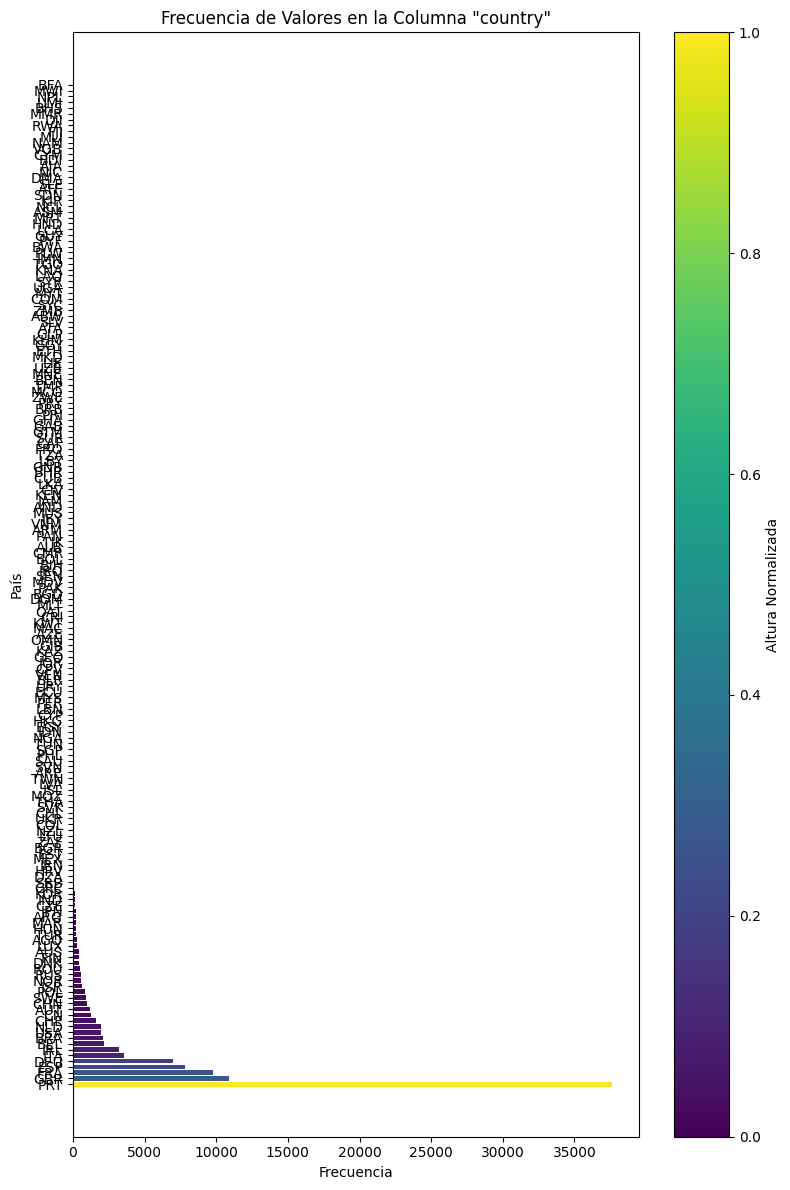

In [ ]:
import matplotlib.pyplot as plt

# Obtener la frecuencia de cada valor en la columna 'country'
country_counts = df['country'].value_counts()

# Crear el histograma horizontal
plt.figure(figsize=(8, 12))
bars = plt.barh(country_counts.index, country_counts.values, color=plt.cm.viridis(country_counts.values / max(country_counts.values)))
plt.title('Frecuencia de Valores en la Columna "country"')
plt.xlabel('Frecuencia')
plt.ylabel('País')
plt.tight_layout()

# Añadir barra de color
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'))
cbar.set_label('Altura Normalizada')

plt.show()


Para reducir dicha cardinalidad podemos obtener los n países que se repiten y asignar el resto a una nueva categoría 'Other'. Por ejemplo, podemos localizar de cuantos países proceden el 90% de los visitantes.

In [ ]:
# Obtener la frecuencia de cada país
country_counts = df['country'].value_counts()

# Calcular el porcentaje acumulado de las frecuencias
cumulative_percentage = country_counts.cumsum() / country_counts.sum()

# Encontrar el índice donde el porcentaje acumulado alcanza o supera el 90%
index_90th_percentile = (cumulative_percentage >= 0.9).idxmax()

# Filtrar los países que alcanzan o superan el percentil 90
top_countries = country_counts[:index_90th_percentile]

print("Número de países necesarios para retener el 90% de los datos:", len(top_countries))


Número de países necesarios para retener el 90% de los datos: 15


Ahora, nos quedamos con los 15 paises que más se repiten y asignamos la etiqueta "Other" al resto. Podemos observar que el país que más se repite es Portugal, aunque entre los más frecuentes también están Gran Bretaña, España, Alemania, Francia e Italia. Luego hay una cola con valores bastante inferiores hasta llegar a AUT (Austria). 'Other' tiene un valor relativamente alto ahora, pero engloba a 160 países, por lo que mantener esas variables no resultaba demasiado representativo.

In [ ]:
# Reducir la cantidad de valores únicos en 'country'
top_countries = df['country'].value_counts().nlargest(15).index #obtener los 15 paises que se repiten más
df.loc[~df['country'].isin(top_countries), 'country'] = 'Other' #etiquetar el resto como 'Other'

Podría ser interesante también normalizar las variables numéricas para que tengan un impacto parecido independientemente de su rango inicial, como ocurre por ejemplo con arrival_date_weak (max 53) comparado con lead_time (máximo 629). Al normalizar evitamos sesgos por escala, pero perdemos interpretabilidad de los datos y se podría disminuir la importancia relativa de las características que tienen una desviación estándar baja.

En principio no vamos a normalizar, pero sería una opción a probar si el modelo no ajusta bien así, esto es, si porcentaje de error de predicción sin normalizar es muy alto.

El siguiente bloque deja preparado el preprocesado para aplicar ambas operaciones (1-hot y escala), aunque en el ejemplo sólo se empleará en 1-hot. Para no tocar el dataframe original, haremos la transformación sobre una copia del mismo (df_post). Nótese que las instrucciones para escalar están comentadas, pero se pueden descomentar si se desea.

Al final, imprimimos los nombres de las nuevas columnas para posterior interpretación de resultados. Nótese que el 1-hot-encoder ha conservado el nombre de la columna original y le ha añadido a continuación las etiquetas de los distintos valores que puede tomar la variable, por ejemplo, una variable x que puede tomar 3 valores (a, b y c), genera 3 columnas x_a, x_b y x_c.

In [ ]:
# Seleccionar columnas numéricas
numerical_columns = df.select_dtypes(include=['number'])

# Seleccionar nombres de las columnas categóricas
categorical_column_names = df.select_dtypes(include=['object']).columns

# Copia el DataFrame original para no modificarlo
df_post = df.copy()

# Aplica OneHotEncoding a las columnas categóricas
one_hot_encoded = pd.get_dummies(df_post, columns=categorical_column_names, prefix=categorical_column_names)

# Obtiene los nombres de las nuevas columnas generadas
new_column_names = one_hot_encoded.columns

# Concatena las columnas codificadas al DataFrame original
df_post = pd.concat([df_post, one_hot_encoded], axis=1)

# Elimina las columnas originales categóricas si es necesario
df_post.drop(columns=categorical_column_names, inplace=True)

# Muestra los nombres de las nuevas columnas
print(df_post.columns)

Index(['is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies',
       ...
       'assigned_room_type_H', 'assigned_room_type_I', 'assigned_room_type_K',
       'deposit_type_No Deposit', 'deposit_type_Non Refund',
       'deposit_type_Refundable', 'customer_type_Contract',
       'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party'],
      dtype='object', length=110)


Ahora que nuestros datos son exclusivamente numéricos, podemos aplicar un árbol de decisión de sklearn. Vamos a añadir por si acaso un SimpleImputer para rellenar posibles valores que falten (lo aplicaremos junto con el árbol con el mecanismo de pipelining de la propia librería).

Previamente a ésto, dividiremos el conjunto de datos a procesar en train y test para evaluar el efecto del overfitting, y cada subset en X (variables independientes) e y (variable dependiente).

No vamos a dedicar tiempo a optimizar el árbol. Simplemente usaremos en DecisionTreeClassifier los parámetros ccp_alpha y max_depth, para controlar respectivamente el podado y la máxima profundidad del mismo.

Una vez obtenido el modelo (pipeline) podemos usar predict para predecir los valores y_pred que corresponden a X_test y compararlos con y_test (los reales) para evaluar la exactitud (accuracy) del mismo, que en este caso es de aproximadamente el 78%.

In [ ]:
from sklearn.impute import SimpleImputer

# Imputar valores faltantes con la media
imputer = SimpleImputer(strategy='mean')
df_post_imputed = pd.DataFrame(imputer.fit_transform(df_post), columns=df_post.columns)

# Separar las variables independientes y la variable dependiente
X = df_post_imputed.drop(columns=['is_canceled'])
y = df_post_imputed['is_canceled']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar y entrenar el modelo de árbol de decisión
DT_model =  DecisionTreeClassifier(ccp_alpha=0.01,max_depth=10)
DT_model.fit(X_train, y_train)


# Predecir sobre el conjunto de prueba
y_pred = DT_model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Exactitud del modelo:", accuracy)

Exactitud del modelo: 0.7840853954391073


Para entender mejor el modelo, podemos representarlo gráficamente usando la función plot_tree. En concreto, esta función representa para cada nodo:
Variable de split: Indica la variable que se utiliza para dividir el conjunto:

*   La variable de split: que se usa para dividir los datos en ese nodo
*   Gini, que indica la impureza del nodo. Cuanto más bajo sea, más homogéneos los datos en ese nodo o, lo que es lo mismo, mayor la probabilidad de acierto del mismo.
*   Samples, o número de muestras que alcanzaron ese nodo.
*   Value, que da la distribución de clases del nodo, por ejemplo, para dos clases [30, 10], significa que hay 30 muestras de la clase 0 y 10 muestras de la clase 1 en ese nodo.
*   Class, que indica la clase mayoritaria en el nodo si se detiene en ese punto (nótese que en pasos posteriores se podrían generar nodos hijo de otra clase distinta)

En cada nodo, si la condición del nodo se cumple, nos desviamos hacia la derecha y si no se cumple, hacia la izquierda. Por ejemplo, en deposit_type_NonRefund < 0.5, si NonRefund es 1, es decir, no nos devuelven la fianza, llegaríamos al nodo terminal de la derecha (azul) y en caso contrario al de la izquierda.


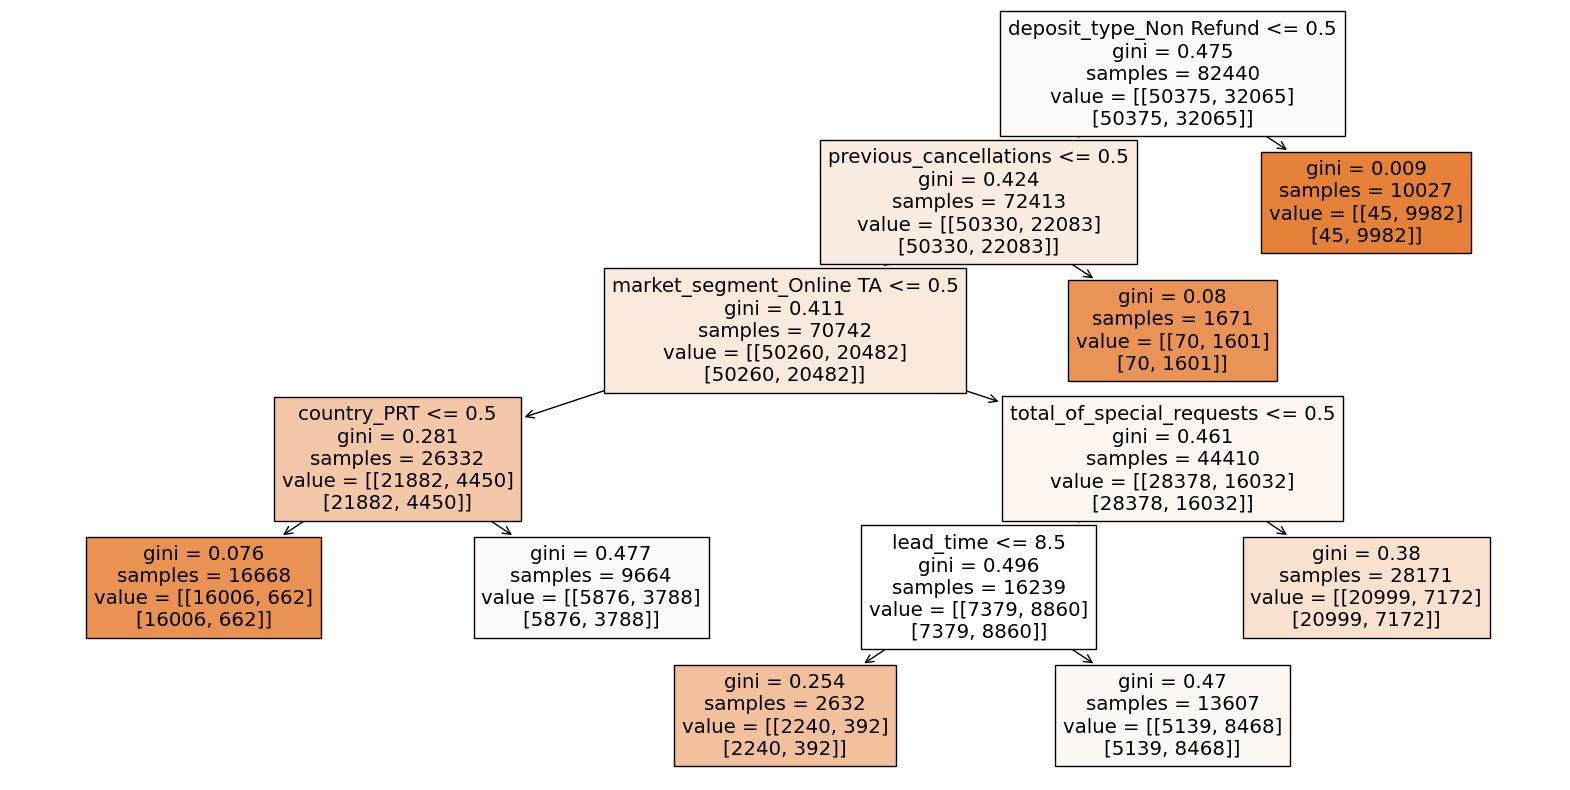

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(DT_model, feature_names=X.columns, class_names=['Not Cancelled', 'Cancelled'], filled=True, max_depth=10)
plt.show()


Si analizamos por encima nuestro árbol, veremos que su profundidad no llega al límte impuesto  10) y que los criterios de división son principalmente si se devuelve o no la fianza, Si ese cliente ha hecho cancelaciones previas, si viene o no de Portugal, si ha solicitado algo especial y la cantidad de días que transcurren desde la fecha de la creación de la reserva hasta la fecha de llegada al hotel (lead_time).

Por ejemplo, siguiendo el árbol vemos que una persona que efectúa una reserva en un hotel sin gastos de cancelación y que ha efectuado cancelaciones con anterioridad en el mismo, es muy probable que vuelva a cancelar (un 2% de la población total). Por otro lado, si nunca había cancelado con anterioridad en ese hotel, no ha usado Agentes para hacer la reserva y el cliente no es de Portugal (el dataset no lo indica pero, por la naturaleza de los datos y los autores del mismo, probablemente se trata de hoteles en Portugal), se predice que no se cancelaría dicha reserva (20% de individuos del dataset).

A continuación, aplicaremos un Random Forest a los mismos datos de que disponemos para comprobar si conseguimos mejorar la exactitud. Como en este caso calculamos 100 árboles, el tiempo de ejecución aumenta, pero a cambio subimos la precisión hasta un 88.8%.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier(n_estimators=100)
# Entrenar el modelo
RF_model.fit(X_train, y_train)

# Predecir con el conjunto de prueba
y_pred = RF_model.predict(X_test)

# Calcular la precisión
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo:", accuracy)

Precisión del modelo: 0.8890829694323145


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión: (TN, FP, FN, TP)")
print(cm)

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Tamaño de la fuente
heatmap = sns.heatmap(cmPCA, annot=True, fmt='d', cmap='Blues', cbar=False)

# Añadir etiquetas de los ejes
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión')

# Mostrar el heatmap
plt.show()

Un Random Forest no se puede visualizar como un DT, pero se pueden comprobar, por ejemplo, las variables que tienen más peso a la hora de tomar las decisiones en el modelo. Por ejemplo, en este caso las 5 más relevantes son ['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights'], esto es el tiempo desde que se realizó la reserva, la fecha de llegada y el número de días en fin de semana de la reserva.

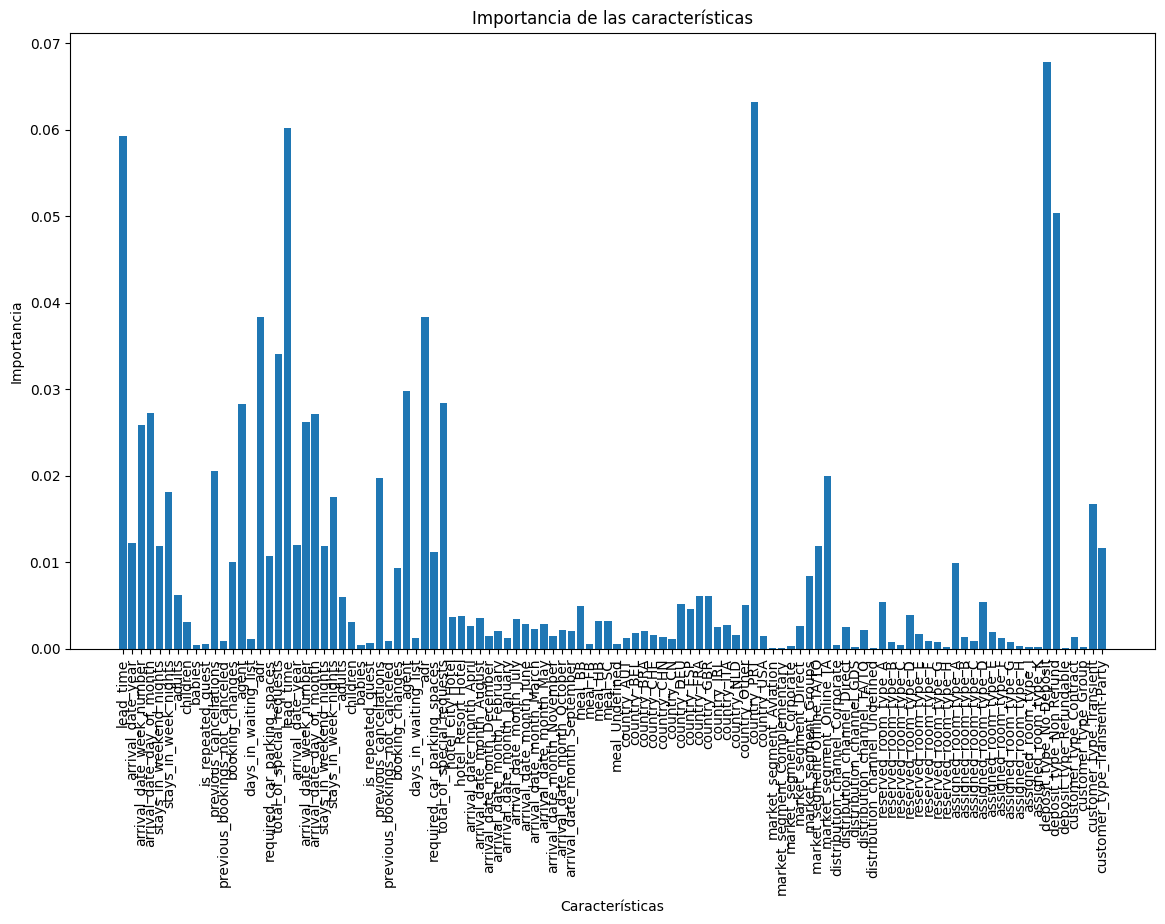

['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights']


In [ ]:
features_names = X.columns.tolist()

# Suponiendo que 'model' es tu modelo Random Forest
feature_importance = RF_model.feature_importances_

# Visualizar la importancia de las características
plt.figure(figsize=(14,8))
plt.bar(range(len(feature_importance)), feature_importance, align='center')
plt.xticks(range(len(feature_importance)), features_names, rotation=90)  # Rotar las etiquetas del eje x en 90 grados
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('Importancia de las características')
plt.show()

top_feature_names = features_names[:5]
print(top_feature_names)